In [3]:
import os
import sys
sys.path.append(r"C:\Users\hjia9\Documents\GitHub\data-analysis\read")
sys.path.append(r"C:\Users\hjia9\Documents\GitHub\data-analysis")

import numpy as np
import matplotlib.pyplot as plt

from read_scope_data import read_trc_data

In [20]:
date = "20241028"
file_number = "00000"

# read data from xray detector scope
base_dir = os.path.join(r"D:\x-ray", date)
for ifn in os.listdir(base_dir):
    if ifn.endswith(f"{file_number}.trc"):
        if "C1" in ifn:
            dipole_data, tarr_x = read_trc_data(os.path.join(base_dir, ifn))
        if "C3" in ifn:
            vis_data, tarr_x = read_trc_data(os.path.join(base_dir, ifn))
        if "C4" in ifn:
            xray_data, tarr_x = read_trc_data(os.path.join(base_dir, ifn))  

# read data from Bdot scope
base_dir = os.path.join(r"D:\Bdot", date)
for ifn in os.listdir(base_dir):
    if ifn.endswith(f"{file_number}.trc"):
        if "C1" in ifn:
            By_P21, tarr_B = read_trc_data(os.path.join(base_dir, ifn))
        if "C2" in ifn:
            Bx_P20, tarr_B = read_trc_data(os.path.join(base_dir, ifn))
        if "C3" in ifn:
            By_P20, tarr_B = read_trc_data(os.path.join(base_dir, ifn))

# read data from magnetron scope
base_dir = os.path.join(r"D:\magnetron", date)
for ifn in os.listdir(base_dir):
    if ifn.endswith(f"{file_number}.trc"):
        if "C1" in ifn:
            V1, tarr = read_trc_data(os.path.join(base_dir, ifn))
            V_bank = np.average(V1)
            print(f"Bank voltage = {V_bank}")
        if "C2" in ifn:
            I_mag, tarr = read_trc_data(os.path.join(base_dir, ifn))
            
        if "C3" in ifn:
            P_ref, tarr = read_trc_data(os.path.join(base_dir, ifn))
            print(f"Read P_ref from {ifn}")

        if "C4" in ifn:
            V_mag, tarr = read_trc_data(os.path.join(base_dir, ifn))
        
        if 'I_mag' in locals() and 'V_mag' in locals():
            P_mag = -I_mag*0.25*V_mag # 1V = 0.25A; magnetron is negatively biased


Reading data...
Done
Reading data...
Done
Reading data...
Done
Reading data...
Done
Reading data...
Done
Reading data...
Done
Reading data...
Done
Reading data...
Done
Reading data...
Done
Reading data...
Done
Bank voltage = 202.80370871267806
Reading data...
Done
Reading data...
Done
Read P_ref from C3--E-ring-wt-Tungsten2mm--00000.trc
Reading data...
Done


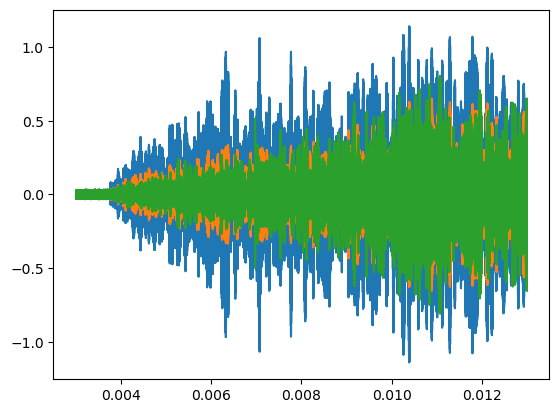

In [23]:
plt.figure()
plt.plot(tarr_B, Bx_P20)
plt.plot(tarr_B, By_P20)
plt.plot(tarr_B, By_P21)
plt.show()
